In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

C:\Users\Sol\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


In [4]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


In [5]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'originated', 'a', 'term', 'as', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['anarchism', 'term', 'originated', 'a', 'originated', 'term', 'as', 'of']


In [12]:
batch_size = 64
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [13]:
num_steps = 500001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.732894
Nearest to four: breath, emirates, determinate, triad, sapporo, cycled, questioning, foal,
Nearest to many: gantry, atv, aguilera, friendship, gellius, eurocard, validated, rebelled,
Nearest to from: illegitimacy, disenchantment, tur, sil, lcms, hallmark, monaghan, leveraged,
Nearest to were: standpoint, amazement, utraquists, inhabits, jetty, permeated, fierce, pendragon,
Nearest to american: narrative, forcing, plated, shipyard, hmac, sw, sour, mejid,
Nearest to a: melancholy, transporters, trillion, meditator, flybys, sst, relapse, transplant,
Nearest to for: mambo, xxix, reymond, dubbed, sommerfeld, nutation, dermot, seem,
Nearest to their: harvest, hofstadter, healthier, ratio, internecine, dirty, drumlins, rabbah,
Nearest to use: gavrilo, fluoride, negus, swallowed, charlie, bek, automatism, woodcut,
Nearest to be: inducted, peptidoglycan, pot, unionist, graduates, convicts, salute, nibble,
Nearest to may: aramaic, relationships, israe

Average loss at step 52000: 3.438621
Average loss at step 54000: 3.325977
Average loss at step 56000: 3.443491
Average loss at step 58000: 3.417840
Average loss at step 60000: 3.386271
Nearest to four: five, six, eight, three, nine, seven, two, zero,
Nearest to many: some, several, various, such, these, whores, most, other,
Nearest to from: between, during, into, under, across, of, in, indentation,
Nearest to were: are, have, was, although, had, those, be, include,
Nearest to american: english, french, russian, worcestershire, british, haas, german, lombards,
Nearest to a: the, another, any, greenstone, plotters, supervisory, hermitian, tansley,
Nearest to for: cosgrave, to, frisians, by, citro, dred, when, at,
Nearest to their: its, his, her, the, marianas, our, them, wherever,
Nearest to use: form, return, find, mousa, lesund, play, cause, addition,
Nearest to be: have, been, become, being, is, khayyam, were, driscoll,
Nearest to may: can, will, would, must, should, could, might, can

Average loss at step 114000: 3.382421
Average loss at step 116000: 3.403120
Average loss at step 118000: 3.370753
Average loss at step 120000: 3.382727
Nearest to four: seven, five, two, eight, zero, three, six, nine,
Nearest to many: some, several, various, numerous, most, few, those, these,
Nearest to from: through, in, between, across, toward, into, of, during,
Nearest to were: are, was, have, had, while, those, wimp, these,
Nearest to american: british, italian, german, australian, russian, spanish, canadian, indian,
Nearest to a: the, any, another, altruists, hermitian, every, greenstone, theropods,
Nearest to for: while, against, in, including, among, through, epistolary, scientific,
Nearest to their: its, his, her, our, your, the, whose, these,
Nearest to use: support, carew, share, kind, because, application, removing, way,
Nearest to be: become, been, is, being, produce, cofactor, have, achieve,
Nearest to may: can, might, must, would, could, should, will, cannot,
Nearest to b

Average loss at step 172000: 3.310528
Average loss at step 174000: 3.283268
Average loss at step 176000: 3.268311
Average loss at step 178000: 3.222140
Average loss at step 180000: 3.339072
Nearest to four: six, five, three, two, seven, eight, nine, zero,
Nearest to many: several, some, various, numerous, those, these, all, certain,
Nearest to from: across, via, into, through, pandemic, booker, under, indentation,
Nearest to were: are, was, have, had, those, be, remain, is,
Nearest to american: english, canadian, british, australian, italian, german, polish, sacrum,
Nearest to a: another, the, any, theropods, hervey, hailed, inundated, grandpa,
Nearest to for: without, oud, homeostasis, to, of, against, shogunate, cosgrave,
Nearest to their: its, her, his, your, our, my, the, whose,
Nearest to use: argo, carew, need, support, speak, release, application, mutinies,
Nearest to be: have, been, become, remain, were, refer, easily, get,
Nearest to may: might, could, can, should, must, would

Average loss at step 232000: 3.128583
Average loss at step 234000: 2.938574
Average loss at step 236000: 3.269120
Average loss at step 238000: 3.250971
Average loss at step 240000: 3.233037
Nearest to four: five, three, seven, six, eight, nine, zero, two,
Nearest to many: some, several, numerous, various, these, those, all, most,
Nearest to from: via, across, through, into, by, in, within, during,
Nearest to were: are, was, those, have, tend, had, been, ornithology,
Nearest to american: australian, african, italian, british, america, canadian, european, indian,
Nearest to a: another, the, any, some, lehman, theropods, gre, hervey,
Nearest to for: in, without, while, and, including, when, with, using,
Nearest to their: its, her, his, whose, our, your, the, my,
Nearest to use: share, need, comparison, support, basis, release, modern, allow,
Nearest to be: been, have, become, produce, get, seem, receive, choose,
Nearest to may: might, can, would, could, should, must, will, cannot,
Nearest

Average loss at step 292000: 3.254663
Average loss at step 294000: 3.198921
Average loss at step 296000: 3.083464
Average loss at step 298000: 3.084962
Average loss at step 300000: 3.243923
Nearest to four: five, six, seven, three, nine, eight, two, zero,
Nearest to many: several, some, numerous, various, few, those, these, both,
Nearest to from: across, through, in, via, pandemic, into, using, demonic,
Nearest to were: are, was, include, have, these, had, while, tend,
Nearest to american: australian, canadian, indian, african, european, finnish, british, irish,
Nearest to a: another, every, any, the, hervey, offs, hermitian, hailed,
Nearest to for: while, with, although, buffet, of, typical, when, citro,
Nearest to their: its, his, her, your, our, the, my, whose,
Nearest to use: comparison, share, carew, argo, need, application, availability, support,
Nearest to be: get, is, remain, produce, been, become, establish, have,
Nearest to may: can, must, might, should, would, could, will, c

Average loss at step 352000: 3.219579
Average loss at step 354000: 3.226743
Average loss at step 356000: 3.273677
Average loss at step 358000: 3.256663
Average loss at step 360000: 3.200299
Nearest to four: three, five, seven, six, eight, two, nine, zero,
Nearest to many: some, several, numerous, various, those, these, all, most,
Nearest to from: across, through, in, via, under, into, pandemic, during,
Nearest to were: are, have, these, tend, was, those, include, had,
Nearest to american: canadian, australian, irish, italian, english, british, argentine, americans,
Nearest to a: another, any, the, every, theropods, telecasts, hervey, opencourseware,
Nearest to for: unlike, of, midwifery, by, buffet, consumer, after, while,
Nearest to their: its, her, his, our, your, the, my, whose,
Nearest to use: practice, share, standoff, form, argo, allow, speak, offer,
Nearest to be: been, get, become, remain, have, being, produce, seem,
Nearest to may: can, might, could, must, should, would, canno

Average loss at step 412000: 3.085228
Average loss at step 414000: 2.900554
Average loss at step 416000: 3.224076
Average loss at step 418000: 3.078393
Average loss at step 420000: 3.252310
Nearest to four: six, eight, five, three, seven, nine, two, zero,
Nearest to many: some, several, various, numerous, all, these, those, most,
Nearest to from: through, across, via, onto, into, pandemic, in, by,
Nearest to were: are, was, have, those, these, had, remain, tend,
Nearest to american: canadian, scottish, australian, british, argentine, russian, swedish, irish,
Nearest to a: another, the, any, polycarbonate, provincia, seleucus, tabari, or,
Nearest to for: while, despite, of, in, buffet, with, electing, requires,
Nearest to their: its, his, her, your, our, the, my, whose,
Nearest to use: practice, need, basis, available, comparison, support, standoff, msf,
Nearest to be: remain, get, have, been, produce, seem, being, become,
Nearest to may: should, might, can, would, must, could, will, sh

Average loss at step 472000: 3.000141
Average loss at step 474000: 3.036112
Average loss at step 476000: 3.081624
Average loss at step 478000: 3.066628
Average loss at step 480000: 3.200434
Nearest to four: five, six, three, seven, eight, nine, two, zero,
Nearest to many: several, some, numerous, various, multiple, all, countless, most,
Nearest to from: through, into, via, across, asparagales, in, phallus, inside,
Nearest to were: are, had, was, remain, appear, tend, have, those,
Nearest to american: canadian, australian, british, danish, finnish, dutch, swedish, scottish,
Nearest to a: the, any, another, this, something, sufficiently, enough, tufts,
Nearest to for: after, despite, of, without, in, while, buffet, and,
Nearest to their: its, his, our, her, your, my, whose, the,
Nearest to use: practice, usage, most, rendition, comparison, argo, support, validity,
Nearest to be: become, remain, been, being, seem, easily, refer, provide,
Nearest to may: might, must, should, can, could, wo

In [14]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

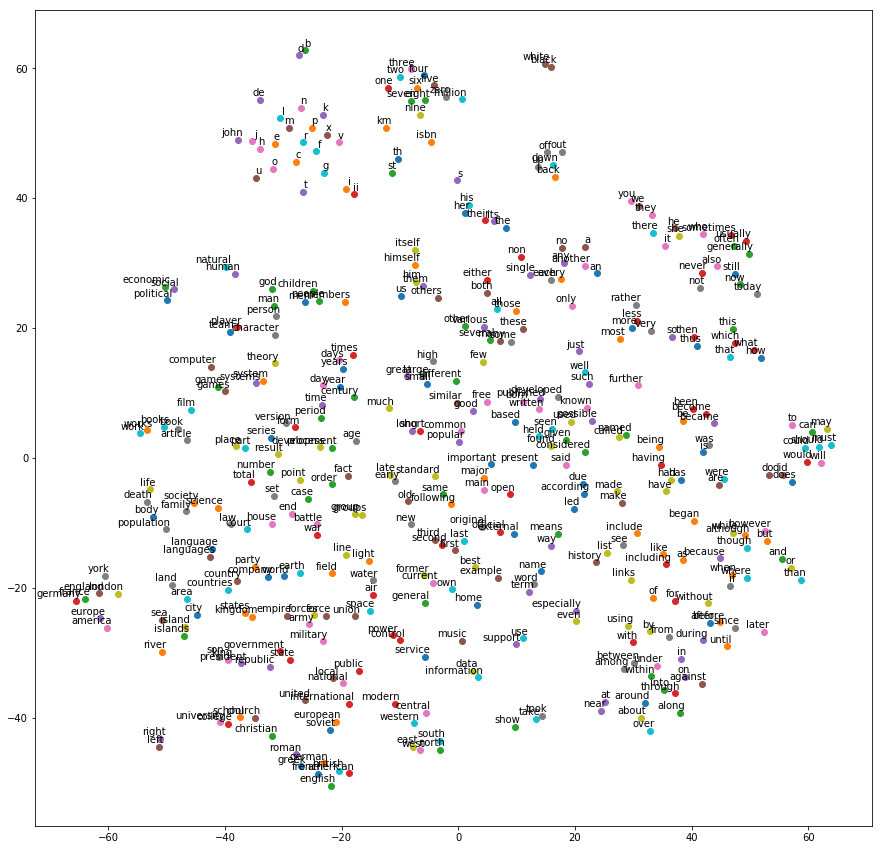

In [15]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)